In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


# **MobileNet**

**GradCAM**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))

# Load MobileNet model
#model = tf.keras.applications.MobileNet(weights="imagenet")
model = load_model('/content/drive/MyDrive/mobilenet_model.h5')

# Path to image
img_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png'

In [ ]:
# Prepare image
img_array = get_img_array(img_path, size=(224, 224))

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, "conv_pw_13_relu")  # Last conv layer for MobileNet

<ipython-input-9-44c773de14bc>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


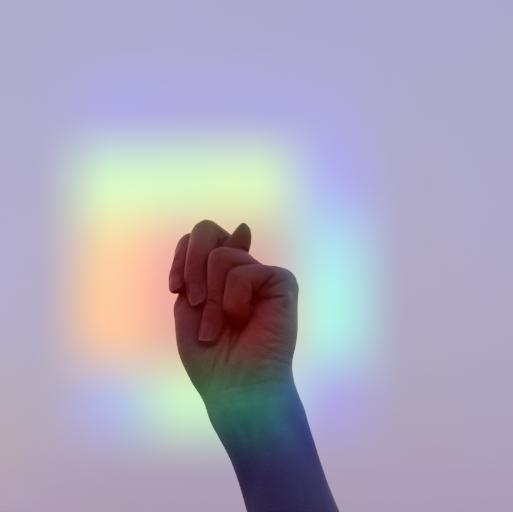

In [ ]:
# Display Grad-CAM
display_gradcam(img_path, heatmap)

**Saliency** **Maps**

In [ ]:
def compute_saliency(model, img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

    # Convert to tensor and watch it
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_idx = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_idx]

    # Compute gradients
    grads = tape.gradient(top_class_channel, img_tensor)
    # Take the maximum absolute value of the gradients over the color channels
    grads = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    return grads.numpy()

def display_saliency(img_path, saliency):
    # Load original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Normalize saliency map for visualization
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))

    # Plot the original image and the saliency map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='jet')
    plt.axis('off')
    plt.show()

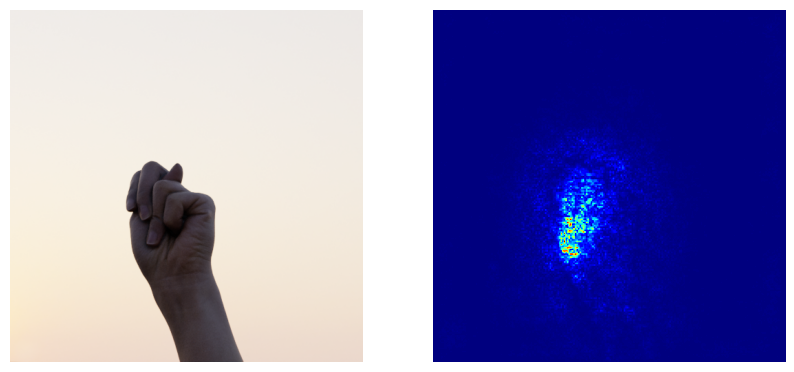

In [ ]:
# Compute saliency
saliency = compute_saliency(model, img_path)

# Display saliency map
display_saliency(img_path, saliency)

**LIME**

In [42]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ee2ee1812ca9ea00b283565e78d6a210947e0d7030af2f23c834206f3c060620
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

def predict(imgs):
    return model.predict(preprocess_input(imgs))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 284ms/step


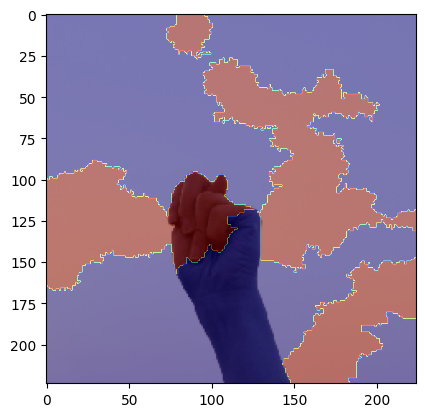

In [44]:
# Path to image
img = preprocess_image(img_path)

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explanation
explanation = explainer.explain_instance(img[0], predict, top_labels=5, hide_color=0, num_samples=1000)

# Display the explanations
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(temp / 2 + 0.5)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.show()

# **EffecientNet**

**GradCAM**

In [37]:
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return tf.keras.applications.efficientnet.preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
# Load EfficientNet model
model1 = load_model('/content/drive/MyDrive/efficientnet_model.h5')

In [39]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

<ipython-input-37-99aead2ba7f3>:35: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
<ipython-input-37-99aead2ba7f3>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


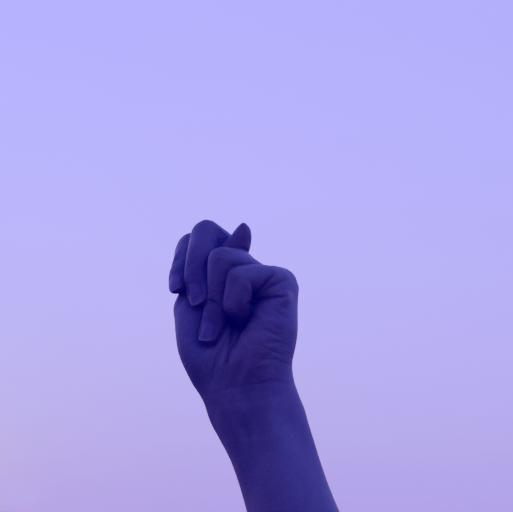

In [40]:
# Prepare image
img_array = get_img_array(img_path, size=(224, 224))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, "top_conv")  # Last conv layer for EfficientNet

# Display Grad-CAM
display_gradcam(img_path, heatmap)

**Saliency** **Maps**

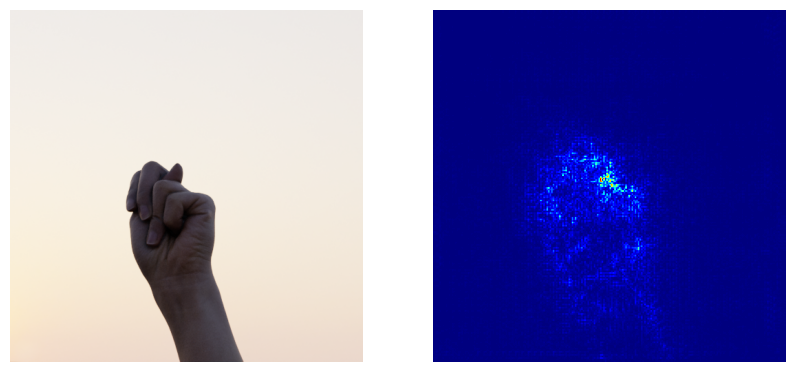

In [ ]:
# Compute saliency
saliency = compute_saliency(model1, img_path)

# Display saliency map
display_saliency(img_path, saliency)

**LIME**

In [45]:
from lime import lime_image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions


def preprocess_image1(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

def predict1(imgs):
    return model1.predict(preprocess_input(imgs))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 627ms/step


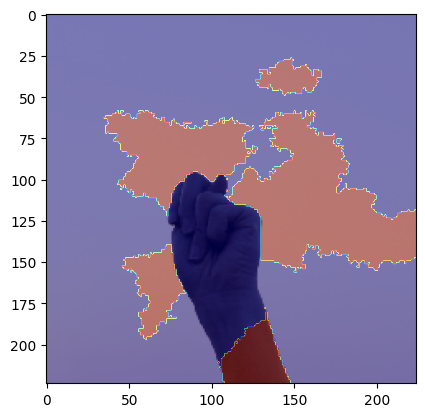

In [46]:
# Path to image
img1 = preprocess_image1(img_path)

# Explanation
explanation1 = explainer.explain_instance(img1[0], predict1, top_labels=5, hide_color=0, num_samples=1000)

# Display the explanations
temp, mask = explanation1.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(temp / 2 + 0.5)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.show()